#Installs and Imports

In [1]:
!pip install shap
!pip install opendatasets

     |████████████████████████████████| 564 kB 3.1 MB/s 


In [2]:
import torch, torchvision
from torch import nn
from torchvision import transforms, models, datasets
import shap
import json
import numpy as np

from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torch.utils.data import DataLoader
import random
import IPython
import torchvision
from PIL import Image

# Download Dataset and initialize dataloaders

In [3]:
## download the Kaggle dataset of COVID lung X-ray 
# get your API from Kaggle, see https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/
import opendatasets as od
import pandas as pd


# Kaggle name and API token
# trevorjchan
# 34cf810a10f5529c45c5d71f318af712

od.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/download")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: trevorjchan
Your Kaggle Key: ··········


100%|██████████| 778M/778M [00:23<00:00, 34.8MB/s]


In [4]:
# create an annotation file of file name + labels within the image directory
img_dir="/content/covid19-radiography-database/COVID-19_Radiography_Dataset/"
covid_images = os.listdir(img_dir+'COVID/images')
covid_images = [img_dir + 'COVID/images/' + img for img in covid_images]
normal_images = os.listdir(img_dir+'Normal/images')
normal_images = [img_dir + 'Normal/images/' + img for img in normal_images]
pneumonia_images= os.listdir(img_dir+'Viral Pneumonia/images')
pneumonia_images = [img_dir + 'Viral Pneumonia/images/' +img for img in pneumonia_images]
# masking folder
covid_mask = os.listdir(img_dir+'COVID/masks')
covid_mask = [img_dir + 'COVID/masks/' + img for img in covid_mask]
normal_mask = os.listdir(img_dir+'Normal/masks')
normal_mask = [img_dir + 'Normal/masks/' + img for img in normal_mask]
pneumonia_mask = os.listdir(img_dir+'Viral Pneumonia/masks')
pneumonia_mask = [img_dir + 'Viral Pneumonia/masks/' +img for img in pneumonia_mask]

# create label
meta_df = pd.DataFrame(data={'data_path':covid_images+normal_images + pneumonia_images,
                             'label':[0]*len(covid_images) + [1]*len(normal_images) + [2]*len(pneumonia_images),
                              'masking': covid_mask+normal_mask + pneumonia_mask})
meta_df.to_csv(img_dir+"all_file_label.txt",sep='\t')

# split into 80% train, 10% validation and 10% test files
random.seed(522)
train_idx = np.random.choice(list(range(meta_df.shape[0])),size=int(meta_df.shape[0]*0.8),replace=False)
val_idx = np.random.choice(list(set(list(range(meta_df.shape[0]))) - set((train_idx))),size=int(meta_df.shape[0]*0.1),replace=False)
test_idx = np.array(list(set(list(range(meta_df.shape[0]))) - set(val_idx) - set(train_idx)))
meta_df.iloc[train_idx,:].to_csv(img_dir+"train_split.txt",sep='\t')
meta_df.iloc[val_idx,:].to_csv(img_dir+"val_split.txt",sep='\t')
meta_df.iloc[test_idx,:].to_csv(img_dir+"test_split.txt",sep='\t')

In [5]:
# customized data loader to save memory
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, train_transform=None,target_transform=None,mask_transform=None,train=True,masking=False, antimasking=False):
        self.annotations_file = pd.read_csv(annotations_file,sep='\t',index_col=0)
        #self.img_dir = img_dir
        self.transform = transform
        self.train_transform = train_transform
        self.train=train
        self.target_tranform= target_transform
        self.masking = masking 
        self.antimasking = antimasking
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.annotations_file)

    def __getitem__(self, idx):
        img_path = self.annotations_file.iloc[idx, 0] # image
        mask_path = self.annotations_file.iloc[idx, 2] # masking
        image = read_image(img_path)
        mask = read_image(mask_path)/255

        ## Change 1x299x299 images to 3x299x299 to keep consistency between datasets.
        if image.shape[0] == 1:
          image = torch.tile(image,(3,1,1))

        # apply masking on image before any other transformation
        if self.masking == True: 
          image = self.mask_transform(image) # resize image to be same size as mask, mask size: 3*256*256
          image = image * mask
        elif self.antimasking == True: 
          image = self.mask_transform(image) # resize image to be same size as mask, mask size: 3*256*256
          image = image * -1 * (1-mask)

        label = self.annotations_file.iloc[idx, 1] # image label, 0 for covid, 1 for normal, 2 for pneumonia

        if self.train: # for training case, additional transformation
            image = self.train_transform(image)
        else:  # for validation and test case
            image = self.transform(image)
        if self.target_tranform != None:
            label = self.target_transform(label)

        return image, label

In [6]:
annotation_file=img_dir+"all_file_label.txt"
train_file = img_dir+"train_split.txt"
val_file = img_dir+"val_split.txt"
test_file = img_dir+"test_split.txt"

# Define image transformations
# transformations - can add more transformation here, like resize for different models, etc.
all_transforms = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((224, 224)), 
                    transforms.ToTensor(), 
                    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet images common scale factors
                    #transforms.Normalize((0.5), (0.5)), # the covid is only 1D
                    ])

# Make image size size as masking
mask_transform = transforms.Compose([
                    transforms.Resize((256, 256)), 
                    ])
# can add augmentations here for training images
train_transforms = transforms.Compose([
                    transforms.ToPILImage(),
                    # transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(degrees=5), 
                    transforms.Resize((224, 224)), 
                    transforms.ToTensor(), 
                    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    #transforms.Normalize((0.5), (0.5)), # the covid is only 1D
                    ])

full_training_data = CustomImageDataset(
    annotations_file= train_file,
    transform=all_transforms,
    train_transform = train_transforms,
    train=True,
    masking=False,
    antimasking=False,
    mask_transform=mask_transform
)
full_val_data = CustomImageDataset(
    annotations_file= val_file,
    transform=all_transforms,
    train=False,
    masking=False,
    antimasking=False,
    mask_transform=mask_transform
)
full_test_data = CustomImageDataset(
    annotations_file= test_file,
    transform=all_transforms,
    train=False,
    masking=False,
    antimasking=False,
    mask_transform=mask_transform
)


mask_training_data = CustomImageDataset(
    annotations_file= train_file,
    transform=all_transforms,
    train_transform = train_transforms,
    train=True,
    masking=True,
    antimasking=False,
    mask_transform=mask_transform
)
mask_val_data = CustomImageDataset(
    annotations_file= val_file,
    transform=all_transforms,
    train=False,
    masking=True,
    antimasking=False,
    mask_transform=mask_transform
)
mask_test_data = CustomImageDataset(
    annotations_file= test_file,
    transform=all_transforms,
    train=False,
    masking=True,
    antimasking=False,
    mask_transform=mask_transform
)


anti_training_data = CustomImageDataset(
    annotations_file= train_file,
    transform=all_transforms,
    train_transform = train_transforms,
    train=True,
    masking=False,
    antimasking=True,
    mask_transform=mask_transform
)
anti_val_data = CustomImageDataset(
    annotations_file= val_file,
    transform=all_transforms,
    train=False,
    masking=False,
    antimasking=True,
    mask_transform=mask_transform
)
anti_test_data = CustomImageDataset(
    annotations_file= test_file,
    transform=all_transforms,
    train=False,
    masking=False,
    antimasking=True,
    mask_transform=mask_transform
)

In [7]:
full_train_dataloader = DataLoader(full_training_data, batch_size=64, shuffle=True)
full_val_dataloader = DataLoader(full_val_data, batch_size=64, shuffle=True)
full_test_dataloader = DataLoader(full_test_data, batch_size=64, shuffle=True)

mask_train_dataloader = DataLoader(mask_training_data, batch_size=64, shuffle=True)
mask_val_dataloader = DataLoader(mask_val_data, batch_size=64, shuffle=True)
mask_test_dataloader = DataLoader(mask_test_data, batch_size=64, shuffle=True)

anti_train_dataloader = DataLoader(anti_training_data, batch_size=64, shuffle=True)
anti_val_dataloader = DataLoader(anti_val_data, batch_size=64, shuffle=True)
anti_test_dataloader = DataLoader(anti_test_data, batch_size=64, shuffle=True)

In [8]:
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]

mean = [.5,.5,.5]
std = [.2,.2,.2]

def normalize(image):
    if image.max() > 1:
        image /= 255
    # image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

#Download model

In [ ]:
#currently gdown is not working, but download model file from drive directly by following the link
# !gdown --id 1-gRf5YhFMFjqQZ5dlgJaBt5pQR8WWJ7C
# !wget https://drive.google.com/file/d/1-gRf5YhFMFjqQZ5dlgJaBt5pQR8WWJ7C/view?usp=sharing

--2022-04-11 15:46:26--  https://drive.google.com/file/d/1-gRf5YhFMFjqQZ5dlgJaBt5pQR8WWJ7C/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 142.250.125.139, 142.250.125.102, 142.250.125.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.125.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?usp=sharing’

view?usp=sharing        [ <=>                ]  64.59K  --.-KB/s    in 0.001s  

2022-04-11 15:46:29 (42.5 MB/s) - ‘view?usp=sharing’ saved [66140]



In [9]:
num_classes = 3
model = torchvision.models.resnet18()
num_ftrs = model.fc.in_features
# Reset final fully connected layer, number of classes = types of Pokemon = 9
model.fc = nn.Linear(num_ftrs, num_classes)

In [17]:
# model.load_state_dict(torch.load('/content/resnet_covid_full.pth'))
# test_dataloader = full_test_dataloader
# model.load_state_dict(torch.load('/content/resnet_covid_mask.pth', map_location=torch.device('cpu')))
# test_dataloader = mask_test_dataloader
model.load_state_dict(torch.load('/content/resnet_covid_anti.pth', map_location=torch.device('cpu')))
test_dataloader = anti_test_dataloader
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

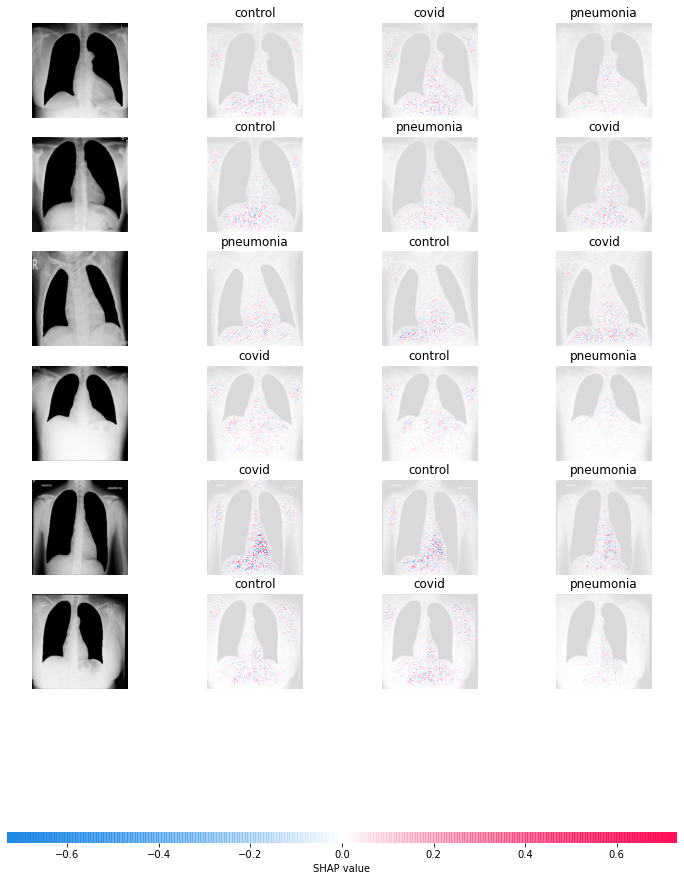

In [18]:
# X,y = shap.datasets.imagenet50()
#X and y are images and labels, in shape (batch,width,height,channel), (batch,)


X,y = next(iter(test_dataloader))
X = np.array(X.permute(0,2,3,1))

#
# X = np.array(Image.open('COVID-1002.png'))
# X = np.tile(np.expand_dims(X, axis=2), (1,1,1,3)).astype(float)
# y = 0
# to_explain = X[[0]]
#

to_explain = X[[0,1,2,3,4,5]]

class_names ={ 
  0: "covid", 
  1: "control", 
  2: "pneumonia"
} 
# class_names = json.dumps(dictionary, indent = 4) 

e = shap.GradientExplainer((model, model.conv1), normalize(X))
shap_values,indexes = e.shap_values(normalize(to_explain), ranked_outputs=3, nsamples=200)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[x])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names, show=False)
plt.savefig('SHAPresults_anti.png',format='png',dpi=300)

In [20]:
y

tensor([1, 1, 2, 0, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0])

In [21]:
shap_values[0].shape

(6, 224, 224, 3)

In [ ]:
type(shap_values)
len(shap_values)
shap_values[0]

(1, 299, 299, 3)

In [ ]:
to_explain[0].shape

torch.Size([224, 224, 3])

In [ ]:
index_names

array([['covid', 'control'],
       ['covid', 'control'],
       ['covid', 'control']], dtype='<U7')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


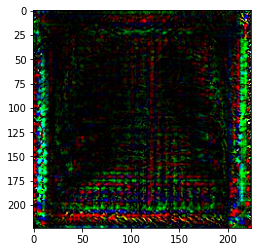

In [ ]:
plt.imshow(shap_values[0][0,:,:,:]*10000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


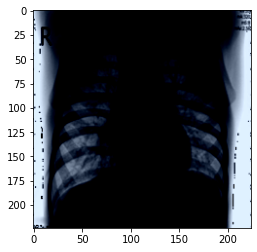

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


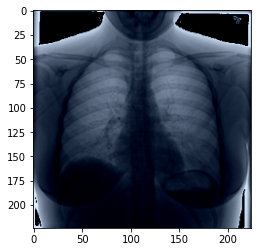

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


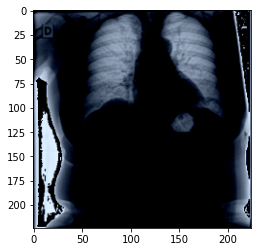

IndexError: ignored

In [ ]:
plt.imshow(to_explain[0]*100)
plt.show()
plt.imshow(to_explain[1]*100)
plt.show()
plt.imshow(to_explain[2]*100)
plt.show()

In [ ]:
shap_values
index_names

array([['covid', 'control'],
       ['covid', 'control'],
       ['covid', 'control']], dtype='<U7')

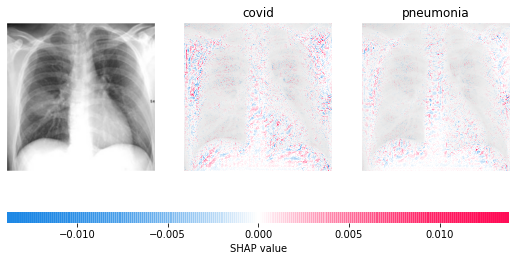

In [ ]:
# note that because the inputs are scaled to be between 0 and 1, the local smoothing also has to be
# scaled compared to the Keras model
explainer = shap.GradientExplainer((model, model.conv1), normalize(X), local_smoothing=0.5)
shap_values,indexes = explainer.shap_values(normalize(to_explain), ranked_outputs=2, nsamples=200)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[x])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)



In [ ]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_dataloader))
images, _ = batch

background = images[:100]
test_images = images[100:103]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

In [ ]:
shap_numpy

[array([], shape=(0, 224, 224, 3), dtype=float64),
 array([], shape=(0, 224, 224, 3), dtype=float64),
 array([], shape=(0, 224, 224, 3), dtype=float64)]

In [ ]:
test_numpy

array([], shape=(0, 224, 224, 3), dtype=float32)

In [ ]:
shap_values

[array([], shape=(0, 3, 224, 224), dtype=float64),
 array([], shape=(0, 3, 224, 224), dtype=float64),
 array([], shape=(0, 3, 224, 224), dtype=float64)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


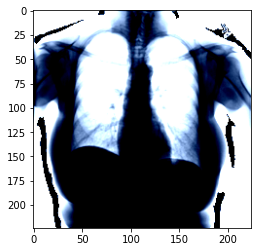

In [ ]:
plt.imshow(background[0].permute(1,2,0))

In [ ]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

UnboundLocalError: ignored

<Figure size 864x180 with 0 Axes>